# Octave DSP Notebook

Signal processing with Octave - great for analyzing instrument harmonics!

In [1]:
% Load the signal processing package
pkg load signal;
pkg load image;

% Set up plotting
graphics_toolkit('gnuplot');

printf('Octave DSP ready ...\n');

Octave DSP ready ...


## Helper Functions

In [2]:
% Find and display harmonics from a spectrum
% Find and display harmonics from a spectrum
function [peak_freqs, peak_amps] = find_harmonics(signal, fs, window_size)
    if nargin < 3
        window_size = 4096;
    end
    
    % Take a chunk and apply window
    chunk_size = min(window_size, length(signal));
    chunk = signal(1:chunk_size) .* hanning(chunk_size);
    
    % Zero-pad for better frequency resolution
    padded = [chunk; zeros(window_size - chunk_size, 1)];
    
    % Compute spectrum
    spectrum = abs(fft(padded));
    spectrum_db = 20 * log10(spectrum(1:window_size/2) + 1e-10);
    
    % Shift spectrum to be positive for findpeaks
    min_db = min(spectrum_db);
    spectrum_shifted = spectrum_db - min_db;
    
    % Frequency axis
    freqs = (0:window_size/2-1)' * fs / window_size;
    
    % Find peaks
    [pks, locs] = findpeaks(spectrum_shifted, 'MinPeakHeight', max(spectrum_shifted) - 40, ...
                                              'MinPeakDistance', 10);
    
    % Return actual dB values (not shifted)
    peak_freqs = freqs(locs);
    peak_amps = spectrum_db(locs);
    
    % Sort by frequency
    [peak_freqs, idx] = sort(peak_freqs);
    peak_amps = peak_amps(idx);
end

function print_harmonics(peak_freqs, peak_amps)
    if isempty(peak_freqs)
        printf('No peaks found\n');
        return;
    end
    
    fundamental = peak_freqs(1);
    
    printf('%-12s %12s %10s\n', 'Frequency', 'Amplitude', 'Ratio');
    printf('%s\n', repmat('-', 1, 36));
    
    for i = 1:length(peak_freqs)
        ratio = peak_freqs(i) / fundamental;
        printf('%-12.1f %12.1f %10.2f\n', peak_freqs(i), peak_amps(i), ratio);
    end
end

printf('Helper functions loaded!\n');

Helper functions loaded!


## Baseline: Sine and Synthetic Examples

### Sine Tone

Let's establish our first baseline using a sine tone at 440 Hz

In [3]:
% Generate a pure 440 Hz sine wave
fs = 44100;
duration = 1.0;
t = (0:1/fs:duration-1/fs)';
f0 = 440.0;  % A4

sine = sin(2*pi*f0*t);

printf('Generated 440 Hz sine wave: %d samples\n', length(sine));

Generated 440 Hz sine wave: 44100 samples


In [4]:
% Analyze harmonics
[freqs, amps] = find_harmonics(sine, fs, 8192);
print_harmonics(freqs, amps);

Frequency       Amplitude      Ratio
------------------------------------
441.4                65.8       1.00


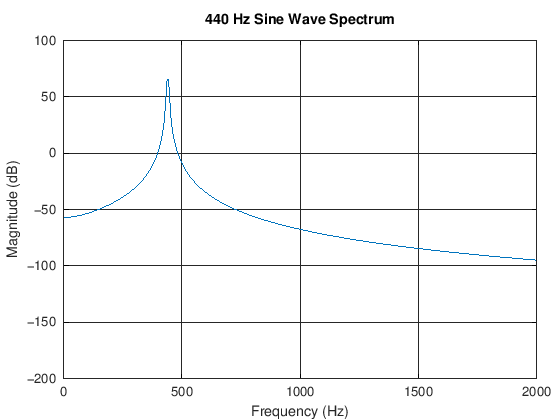

In [5]:
% Plot the spectrum
window_size = 8192;
chunk = sine(1:window_size) .* hanning(window_size);
spectrum = abs(fft(chunk));
spectrum_db = 20 * log10(spectrum(1:window_size/2) + 1e-10);
freq_axis = (0:window_size/2-1)' * fs / window_size;

plot(freq_axis, spectrum_db);
xlim([0 2000]);
xlabel('Frequency (Hz)');
ylabel('Magnitude (dB)');
title('440 Hz Sine Wave Spectrum');
grid on;

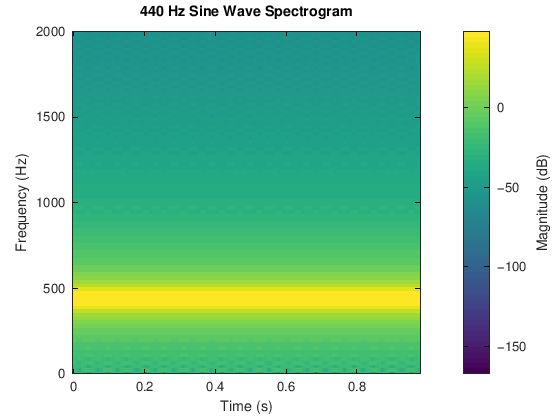

In [6]:
% Create a spectrogram
window = 1024;
overlap = 768;
nfft = 2048;

[S, f, t] = specgram(sine, nfft, fs, window, overlap);

imagesc(t, f, 20*log10(abs(S) + 1e-10));
axis xy;
ylim([0 2000]);
xlabel('Time (s)');
ylabel('Frequency (Hz)');
title('440 Hz Sine Wave Spectrogram');
c = colorbar;
ylabel(c, 'Magnitude (dB)');

### Synthetic Clarinet-like Tone

Clarinets have a distinctive spectrum - odd harmonics are stronger than even harmonics.

In [7]:
% Generate a clarinet-like tone (odd harmonics emphasized)
fs = 44100;
duration = 1.0;
t = (0:1/fs:duration-1/fs)';
f0 = 261.63;  % Middle C

% Clarinet-like: strong odd harmonics, weak even harmonics
clarinet = sin(2*pi*f0*t) + ...
           0.75 * sin(2*pi*3*f0*t) + ...
           0.5 * sin(2*pi*5*f0*t) + ...
           0.14 * sin(2*pi*7*f0*t) + ...
           0.5 * sin(2*pi*9*f0*t) + ...
           0.12 * sin(2*pi*11*f0*t) + ...
           0.17 * sin(2*pi*13*f0*t);

% Normalize
clarinet = clarinet / max(abs(clarinet));

printf('Generated synthetic clarinet tone: %.2f Hz fundamental\n', f0);

Generated synthetic clarinet tone: 261.63 Hz fundamental


In [8]:
% Analyze harmonics
[freqs, amps] = find_harmonics(clarinet, fs, 8192);
print_harmonics(freqs, amps);

Frequency       Amplitude      Ratio
------------------------------------
263.8                60.0       1.00
786.0                58.1       2.98
1308.1               54.8       4.96
1830.3               43.6       6.94
2352.5               53.9       8.92
2880.1               41.6      10.92
3402.2               45.3      12.90


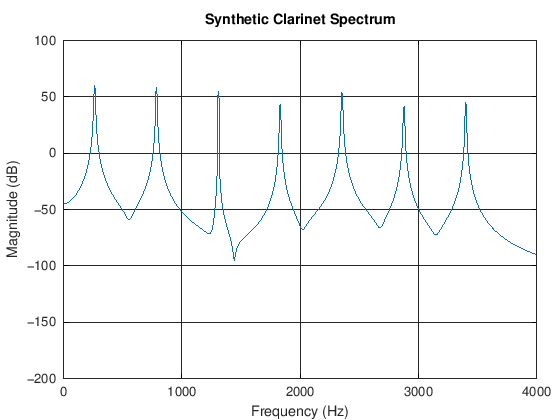

In [9]:
% Plot the spectrum
window_size = 8192;
chunk = clarinet(1:window_size) .* hanning(window_size);
spectrum = abs(fft(chunk));
spectrum_db = 20 * log10(spectrum(1:window_size/2) + 1e-10);
freq_axis = (0:window_size/2-1)' * fs / window_size;

plot(freq_axis, spectrum_db);
xlim([0 4000]);
xlabel('Frequency (Hz)');
ylabel('Magnitude (dB)');
title('Synthetic Clarinet Spectrum');
grid on;

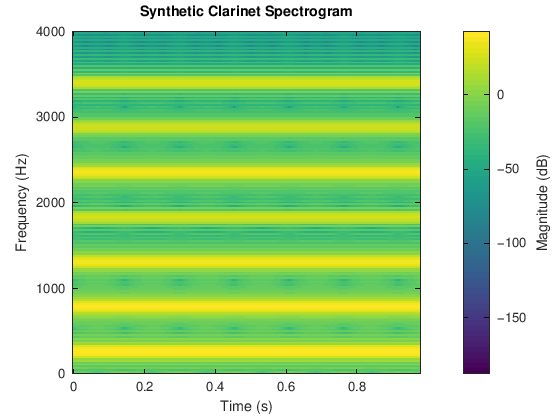

In [10]:
% Create a spectrogram
window = 1024;
overlap = 768;
nfft = 2048;

[S, f, t] = specgram(clarinet, nfft, fs, window, overlap);

imagesc(t, f, 20*log10(abs(S) + 1e-10));
axis xy;
ylim([0 4000]);
xlabel('Time (s)');
ylabel('Frequency (Hz)');
title('Synthetic Clarinet Spectrogram');
c = colorbar;
ylabel(c, 'Magnitude (dB)');

### Synthetic Oboe-like Tone

Oboes have a richer spectrum with both odd and even harmonics present.

In [11]:
% Generate an oboe-like tone (both odd and even harmonics)
f0 = 440.0;  % A4

% Oboe-like: rich harmonic content
oboe = sin(2*pi*f0*t) + ...
       0.6 * sin(2*pi*2*f0*t) + ...
       0.4 * sin(2*pi*3*f0*t) + ...
       0.3 * sin(2*pi*4*f0*t) + ...
       0.35 * sin(2*pi*5*f0*t) + ...
       0.2 * sin(2*pi*6*f0*t) + ...
       0.15 * sin(2*pi*7*f0*t) + ...
       0.1 * sin(2*pi*8*f0*t);

oboe = oboe / max(abs(oboe));

printf('Generated synthetic oboe tone: %.2f Hz fundamental\n', f0);

Generated synthetic oboe tone: 440.00 Hz fundamental


In [12]:
% Analyze oboe harmonics
[freqs, amps] = find_harmonics(oboe, fs, 8192);
print_harmonics(freqs, amps);

error: vertical dimensions mismatch (169x169 vs 8023x1)
error: called from
    find_harmonics at line 11 column 12
Frequency       Amplitude      Ratio
------------------------------------
263.8                60.0       1.00
786.0                58.1       2.98
1308.1               54.8       4.96
1830.3               43.6       6.94
2352.5               53.9       8.92
2880.1               41.6      10.92
3402.2               45.3      12.90


error: oboe(8192): out of bound 169 (dimensions are 1x169)


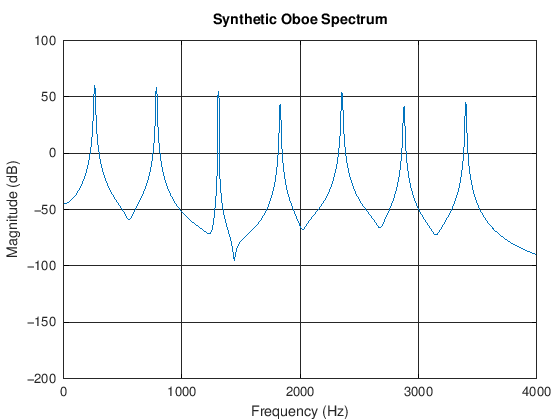

In [13]:
% Plot the spectrum
window_size = 8192;
chunk = oboe(1:window_size) .* hanning(window_size);
spectrum = abs(fft(chunk));
spectrum_db = 20 * log10(spectrum(1:window_size/2) + 1e-10);
freq_axis = (0:window_size/2-1)' * fs / window_size;

plot(freq_axis, spectrum_db);
xlim([0 4000]);
xlabel('Frequency (Hz)');
ylabel('Magnitude (dB)');
title('Synthetic Oboe Spectrum');
grid on;

error: specgram: segment length must be less than the size of X
error: called from
    specgram at line 145 column 5


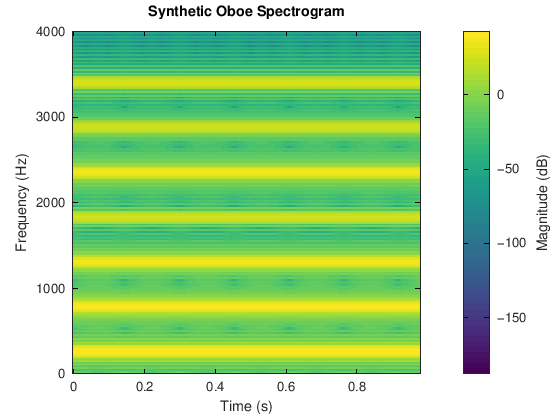

In [14]:
% Create a spectrogram
window = 1024;
overlap = 768;
nfft = 2048;

[S, f, t] = specgram(oboe, nfft, fs, window, overlap);

imagesc(t, f, 20*log10(abs(S) + 1e-10));
axis xy;
ylim([0 4000]);
xlabel('Time (s)');
ylabel('Frequency (Hz)');
title('Synthetic Oboe Spectrogram');
c = colorbar;
ylabel(c, 'Magnitude (dB)');

## Using Actual Instrument Samples

The `.wav` files used below were generated using Spitfire Audio's library "Studio Woodwinds Professional."

### Updated Helper Function

My audio files are about 8 seconds long with silence at the beginning and the end. As such, we need to make an adjustment to our sampler function to pull from the middle:

In [15]:
% Find and display harmonics from a spectrum
function [peak_freqs, peak_amps] = find_harmonics(signal, fs, window_size)
    if nargin < 3
        window_size = 4096;
    end
    
    % Take a chunk from the middle of the file (avoid silence at start/end)
    mid_point = floor(length(signal) / 2);
    start_idx = mid_point - floor(window_size / 2);
    if start_idx < 1
        start_idx = 1;
    end
    chunk_size = min(window_size, length(signal) - start_idx + 1);
    chunk = signal(start_idx:start_idx + chunk_size - 1) .* hanning(chunk_size);
    
    % Zero-pad for better frequency resolution
    padded = [chunk; zeros(window_size - chunk_size, 1)];
    
    % Compute spectrum
    spectrum = abs(fft(padded));
    spectrum_db = 20 * log10(spectrum(1:window_size/2) + 1e-10);
    
    % Shift spectrum to be positive for findpeaks
    min_db = min(spectrum_db);
    spectrum_shifted = spectrum_db - min_db;
    
    % Frequency axis
    freqs = (0:window_size/2-1)' * fs / window_size;
    
    % Calculate peak threshold (handle edge cases)
    peak_threshold = max(spectrum_shifted) - 40;
    if peak_threshold < 0
        peak_threshold = 0;
    end
    
    % Find peaks
    [pks, locs] = findpeaks(spectrum_shifted, 'MinPeakHeight', peak_threshold, ...
                                              'MinPeakDistance', 10);
    
    % Return actual dB values (not shifted)
    peak_freqs = freqs(locs);
    peak_amps = spectrum_db(locs);
    
    % Sort by frequency
    [peak_freqs, idx] = sort(peak_freqs);
    peak_amps = peak_amps(idx);
end

### Clarinet

The following clarinet recording is of E4 with vibrato:

In [16]:
[y, fs] = audioread('audio/clarinet.wav');

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n', length(y), fs);

Loaded: 384000 samples at 48000 Hz


In [17]:
% High-pass filter at 80 Hz to remove DC offset and rumble
[b, a] = butter(4, 80/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
window_size = 8192;
[freqs, amps] = find_harmonics(y, fs, window_size);
print_harmonics(freqs, amps);

Frequency       Amplitude      Ratio
------------------------------------
328.1                44.6       1.00
656.2                32.1       2.00
990.2                48.5       3.02
1318.4               44.5       4.02
1646.5               46.5       5.02
1857.4                9.2       5.66
1980.5               35.8       6.04
2308.6               30.2       7.04
2636.7               26.9       8.04
2970.7               17.3       9.05
3293.0               28.8      10.04
3627.0               28.7      11.05
3949.2               14.0      12.04
4611.3               10.2      14.05
4945.3               18.3      15.07
5267.6               12.0      16.05
5601.6               10.9      17.07


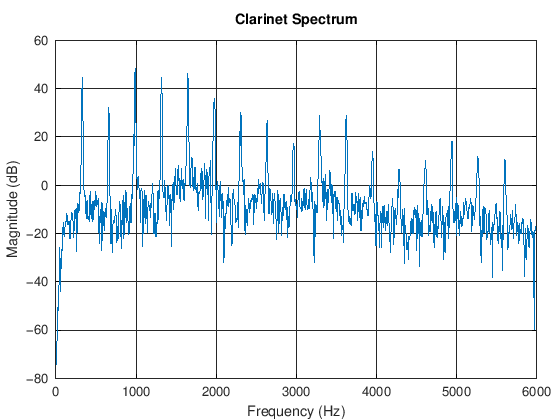

In [18]:
% Plot the spectrum
mid_point = floor(length(y) / 2);
start_idx = mid_point - floor(window_size / 2);
chunk = y(start_idx:start_idx + window_size - 1) .* hanning(window_size);

spectrum = abs(fft(chunk));
spectrum_db = 20 * log10(spectrum(1:window_size/2) + 1e-10);
freq_axis = (0:window_size/2-1)' * fs / window_size;

plot(freq_axis, spectrum_db);
xlim([0 6000]);
xlabel('Frequency (Hz)');
ylabel('Magnitude (dB)');
title('Clarinet Spectrum');
grid on;

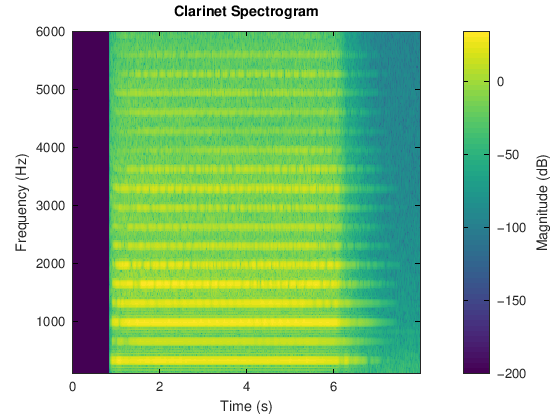

In [19]:
% Create a spectrogram
window = 1024;
overlap = 768;
nfft = 2048;

[S, f, t] = specgram(y, nfft, fs, window, overlap);

imagesc(t, f, 20*log10(abs(S) + 1e-10));
axis xy;
ylim([100 6000]);
xlabel('Time (s)');
ylabel('Frequency (Hz)');
title('Clarinet Spectrogram');
c = colorbar;
ylabel(c, 'Magnitude (dB)');

### Oboe

The following oboe recording is of A4 with vibrato:

In [20]:
[y, fs] = audioread('audio/oboe.wav');

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n\n', length(y), fs);

% High-pass filter at 80 Hz to remove DC offset and rumble
[b, a] = butter(4, 80/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
window_size = 8192;
[freqs, amps] = find_harmonics(y, fs, window_size);
print_harmonics(freqs, amps);

Loaded: 384000 samples at 48000 Hz

Frequency       Amplitude      Ratio
------------------------------------
439.5                33.1       1.00
884.8                39.5       2.01
1324.2               51.6       3.01
1757.8               33.0       4.00
2197.3               30.8       5.00
2648.4               22.9       6.03
3076.2               27.5       7.00
3521.5               25.8       8.01
3955.1               24.1       9.00
4388.7               17.4       9.99


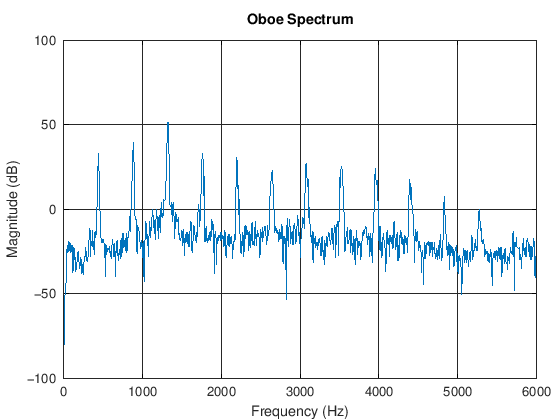

In [21]:
% Plot the spectrum
mid_point = floor(length(y) / 2);
start_idx = mid_point - floor(window_size / 2);
chunk = y(start_idx:start_idx + window_size - 1) .* hanning(window_size);

spectrum = abs(fft(chunk));
spectrum_db = 20 * log10(spectrum(1:window_size/2) + 1e-10);
freq_axis = (0:window_size/2-1)' * fs / window_size;

plot(freq_axis, spectrum_db);
xlim([0 6000]);
xlabel('Frequency (Hz)');
ylabel('Magnitude (dB)');
title('Oboe Spectrum');
grid on;

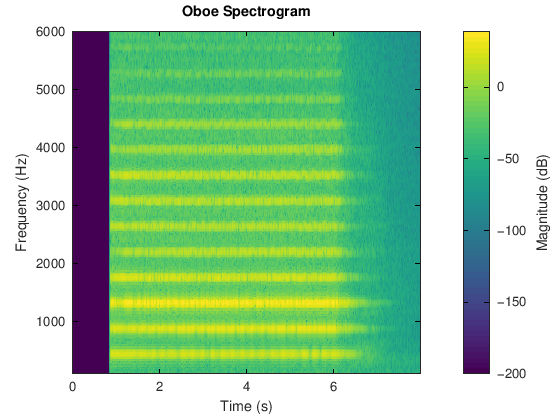

In [22]:
% Create a spectrogram
window = 1024;
overlap = 768;
nfft = 2048;

[S, f, t] = specgram(y, nfft, fs, window, overlap);

imagesc(t, f, 20*log10(abs(S) + 1e-10));
axis xy;
ylim([100 6000]);
xlabel('Time (s)');
ylabel('Frequency (Hz)');
title('Oboe Spectrogram');
c = colorbar;
ylabel(c, 'Magnitude (dB)');

### Oboe and Clarinet Together

In [23]:
[y, fs] = audioread('audio/together.wav');

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n\n', length(y), fs);

% High-pass filter at 80 Hz to remove DC offset and rumble
[b, a] = butter(4, 80/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
window_size = 8192;
[freqs, amps] = find_harmonics(y, fs, window_size);
print_harmonics(freqs, amps);

Loaded: 384000 samples at 48000 Hz

Frequency       Amplitude      Ratio
------------------------------------
328.1                33.1       1.00
439.5                31.2       1.34
656.2                20.5       2.00
884.8                37.6       2.70
990.2                37.0       3.02
1324.2               49.4       4.04
1646.5               35.0       5.02
1757.8               31.1       5.36
1980.5               24.3       6.04
2197.3               29.0       6.70
2308.6               18.7       7.04
2642.6               22.1       8.05
3076.2               25.6       9.38
3293.0               17.2      10.04
3521.5               23.9      10.73
3627.0               17.1      11.05
3955.1               22.9      12.05
4388.7               15.6      13.38


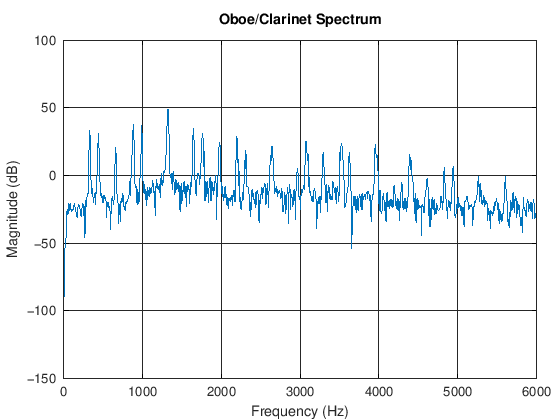

In [24]:
% Plot the spectrum
mid_point = floor(length(y) / 2);
start_idx = mid_point - floor(window_size / 2);
chunk = y(start_idx:start_idx + window_size - 1) .* hanning(window_size);

spectrum = abs(fft(chunk));
spectrum_db = 20 * log10(spectrum(1:window_size/2) + 1e-10);
freq_axis = (0:window_size/2-1)' * fs / window_size;

plot(freq_axis, spectrum_db);
xlim([0 6000]);
xlabel('Frequency (Hz)');
ylabel('Magnitude (dB)');
title('Oboe/Clarinet Spectrum');
grid on;

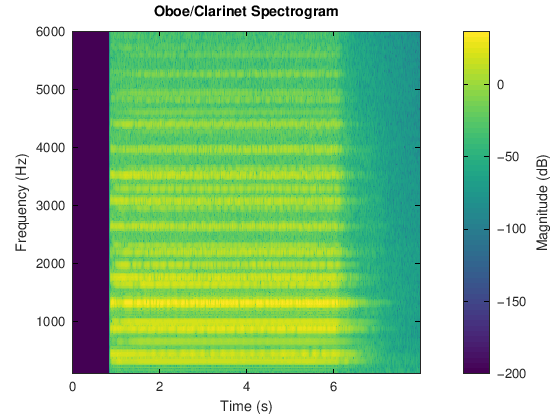

In [25]:
% Create a spectrogram
window = 1024;
overlap = 768;
nfft = 2048;

[S, f, t] = specgram(y, nfft, fs, window, overlap);

imagesc(t, f, 20*log10(abs(S) + 1e-10));
axis xy;
ylim([100 6000]);
xlabel('Time (s)');
ylabel('Frequency (Hz)');
title('Oboe/Clarinet Spectrogram');
c = colorbar;
ylabel(c, 'Magnitude (dB)');